In [ ]:
import pandas as pd

# Reload the dataset (ensure you have the correct file path)
df = pd.read_csv("/content/drive/MyDrive/WAVY/itms_22Mar_2hours.csv")

# Ensure necessary columns exist before creating derived ones
if "speed" in df.columns and "trip_delay" in df.columns:
    # Convert trip_delay to hours
    df["trip_delay_hours"] = df["trip_delay"] / 60

    # Calculate Total Distance Traveled
    df["total_distance_traveled"] = df["speed"] * df["trip_delay_hours"]

    # Estimate Fuel Consumption using BMTC Diesel efficiency (3.5 km per liter)
    df["fuel_consumption"] = df["total_distance_traveled"] / 3.5

    # Calculate CO2 Emissions (Diesel Emission Factor = 2.31 kg CO₂ per liter)
    df["CO2_emissions"] = df["fuel_consumption"] * 2.31

    print("✅ Successfully recreated CO2_emissions and related columns!")
else:
    print("🚨 Required columns like `speed` or `trip_delay` are missing! Check dataset structure.")

# Ensure necessary columns exist
if "total_distance_traveled" in df.columns and "fuel_consumption" in df.columns:
    df["CO2_emissions"] = df["fuel_consumption"] * 2.31  # Using Diesel emission factor (2.31 kg CO₂ per liter)
else:
    print("🚨 Required columns missing! Check dataset structure.")

# Recalculate necessary columns if needed
df["total_distance_traveled"] = df["speed"] * df["trip_delay_hours"]
df["fuel_consumption"] = df["total_distance_traveled"] / 3.5  # Using BMTC Diesel efficiency
df["efficiency_factor"] = df["speed"] / (df["trip_delay_hours"] + 1e-6)  # Avoid division by zero

# Replace inf and NaN values
import numpy as np
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number])

# Fill NaNs in numeric columns only
df[numeric_cols.columns] = df[numeric_cols.columns].fillna(numeric_cols.median())

# Define features
X = df[["speed", "trip_delay_hours", "total_distance_traveled", "fuel_consumption", "efficiency_factor"]]
y = df["CO2_emissions"]


✅ Successfully recreated CO2_emissions and related columns!


In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define feature set
X = df[["speed", "trip_delay_hours", "total_distance_traveled", "fuel_consumption"]]
y = df["CO2_emissions"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost - MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGBoost - RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost R² Score:", r2_score(y_test, y_pred_xgb))

XGBoost - MAE: 1.9034896813948041
XGBoost - RMSE: 19.006556742906774
XGBoost R² Score: 0.9961547017495356


In [ ]:
import pickle

# Save the trained XGBoost model
with open("co2_emission_xgb_2final.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

print("XGBoost model saved as co2_emission_xgb_2final.pkl")


XGBoost model saved as co2_emission_xgb_2final.pkl


In [ ]:
import pickle

# Load the trained model
with open("/content/drive/MyDrive/WAVY/co2_emission_xgb_2final.pkl", "rb") as f:
    xgb_model = pickle.load(f)


In [ ]:
from sklearn.model_selection import train_test_split

# Define feature set
X = df[["speed", "trip_delay_hours", "total_distance_traveled", "fuel_consumption"]]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, df["CO2_emissions"], test_size=0.2, random_state=42)


# **SHAP Summary Plot**
- Most important features affecting CO₂ emissions.
- Features at the top have the most impact.
- Red = high feature values; blue = low feature values.

 98%|===================| 24570/24976 [00:40<00:00]       

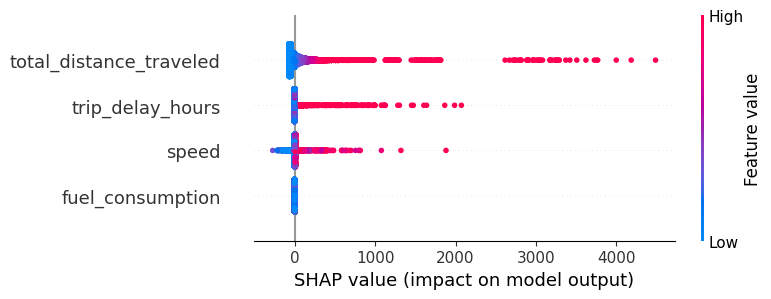

In [ ]:
import shap

# Explain the model
explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_test)


# **Required User Inputs**
1.   Speed of the bus (in km/h) → "speed"
2.   Trip delay (in minutes) → "trip_delay"

# **How the Model Derives Additional Features**
Once the user provides speed and trip delay, the model automatically calculates:

1.   Trip delay in hours → trip_delay_hours = trip_delay / 60
2.   Total distance traveled → total_distance_traveled = speed * trip_delay_hours
3. Fuel consumption → fuel_consumption = total_distance_traveled / 3.5
4. CO₂ emissions → fuel_consumption * 2.31


In [ ]:
import pickle

# Load the trained model
with open("/content/drive/MyDrive/WAVY/co2_emission_xgb_2final.pkl", "rb") as f:
    xgb_model = pickle.load(f)


In [ ]:

# Get user input
speed = float(input("Enter bus speed (km/h): "))
trip_delay = float(input("Enter trip delay (minutes): "))

# Convert trip delay to hours
trip_delay_hours = trip_delay / 60

# Calculate Total Distance Traveled
total_distance_traveled = speed * trip_delay_hours

# Estimate Fuel Consumption (Diesel efficiency = 3.5 km per liter)
fuel_consumption = total_distance_traveled / 3.5

# Create a DataFrame for prediction
import pandas as pd
user_input = pd.DataFrame([[speed, trip_delay_hours, total_distance_traveled, fuel_consumption]],
                          columns=["speed", "trip_delay_hours", "total_distance_traveled", "fuel_consumption"])


Enter bus speed (km/h): 30
Enter trip delay (minutes): 100


In [ ]:
# Predict CO₂ emissions for the user input
predicted_emission = xgb_model.predict(user_input)

# Display the result
print(f"Predicted CO₂ Emissions: {predicted_emission[0]:.2f} kg per trip")


Predicted CO₂ Emissions: 32.55 kg per trip
